<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/marcoteran/deeplearning/blob/master/notebooks/1.2_machinelearning_imbalanceddata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Abrir en Colab" title="Abrir y ejecutar en Google Colaboratory"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/marcoteran/deeplearning/blob/master/notebooks/1.2_machinelearning_imbalanceddata.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" alt="Abrir en Kaggle" title="Abrir y ejecutar en Kaggle"/></a>
  </td>
</table>

## Ejemplos de código
# Autoencoders y GANs

**Name:** Marco Teran
**E-mail:** marco.teran@usa.edu.co

[Website](http://marcoteran.github.io/),
[Github](https://github.com/marcoteran),
[LinkedIn](https://www.linkedin.com/in/marcoteran/).
___

### Preparación del entorno y descarga de datos

Empezamos con las importaciones estándar para preparar el entorno.

#### Importar TensorFlow 2.0

In [1]:
import tensorflow as tf
from tensorflow import keras
print(tf.__version__)

2.13.0


Importar todos los paquetes necesarios para ejecutar el modelo propuesto

In [2]:
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import sys

Defina los tamaños de letra por defecto para que las figuras sean más bonitas:

In [3]:
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

Vamos a crear la carpeta `images/generative` (si no existe ya)

In [4]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "generative"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

Este código puede ser muy lento sin una GPU, así que asegurémonos de que haya una, o de lo contrario emitamos una advertencia:

In [5]:
if not tf.config.list_physical_devices('GPU'):
    print("No se ha detectado ninguna GPU. Las redes neuronales pueden ser muy lentas sin una GPU.")
    if "google.colab" in sys.modules:
        print("Ve a Tiempo de ejecución > Cambiar tiempo de ejecución y selecciona un hardware de GPU "
              "acelerador.")
    if "kaggle_secrets" in sys.modules:
        print("Ve a Configuración > Acelerador y selecciona GPU.")

___

## Performing PCA with an Undercomplete Linear Autoencoder

Construyamos el Autoencoder...

In [6]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU

encoder = tf.keras.Sequential([tf.keras.layers.Dense(2)])
decoder = tf.keras.Sequential([tf.keras.layers.Dense(3)])

In [7]:
autoencoder = tf.keras.Sequential([encoder, decoder])

In [8]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.5)

In [9]:
autoencoder.compile(loss="mse", optimizer=optimizer)

Ahora vamos a generar el mismo conjunto de datos 3D

In [10]:
import numpy as np
from scipy.spatial.transform import Rotation

m = 60
X = np.zeros((m, 3))  # initialize 3D dataset
np.random.seed(42)
angles = (np.random.rand(m) ** 3 + 0.5) * 2 * np.pi  # uneven distribution
X[:, 0], X[:, 1] = np.cos(angles), np.sin(angles) * 0.5  # oval
X += 0.28 * np.random.randn(m, 3)  # add more noise
X = Rotation.from_rotvec([np.pi / 29, -np.pi / 20, np.pi / 4]).apply(X)
X_train = X + [0.2, 0, 0.2]  # shift a bit

In [11]:
history = autoencoder.fit(X_train, X_train, epochs=500, verbose=False)

In [12]:
codings = encoder.predict(X_train)

2/2 [==============================] - 0s 4ms/step


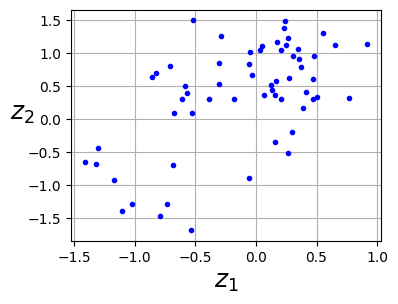

In [13]:
fig = plt.figure(figsize=(4,3))
plt.plot(codings[:,0], codings[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)
plt.show()

___

# Stacked Autoencoders

## Implementación de un Stacked Autoencoder con Keras

Carguemos el conjunto de datos MNIST de moda, escalémoslo y dividámoslo en un conjunto de entrenamiento, un conjunto de validación y un conjunto de prueba:

In [14]:
# extra code – loads, scales, and splits the fashion MNIST dataset
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist

4422102/4422102 [==============================] - 0s 0us/step


In [15]:
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

Construyamos y entrenemos un Autoencoder apilado con 3 capas ocultas y 1 capa de salida (es decir, 2 Autoencoders apilados).

In [16]:
stacked_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(30, activation="relu"),
])
stacked_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(28 * 28),
    tf.keras.layers.Reshape([28, 28])
])

In [17]:
stacked_ae = tf.keras.Sequential([stacked_encoder, stacked_decoder])

In [18]:
stacked_ae.compile(loss="mse", optimizer="nadam")

In [19]:
history = stacked_ae.fit(X_train, X_train, epochs=20,
                         validation_data=(X_valid, X_valid))

Epoch 1/20
1719/1719 [==============================] - 15s 6ms/step - loss: 0.0235 - val_loss: 0.0181
Epoch 2/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0169 - val_loss: 0.0165
Epoch 3/20
1719/1719 [==============================] - 8s 4ms/step - loss: 0.0159 - val_loss: 0.0159
Epoch 4/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0154 - val_loss: 0.0154
Epoch 5/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0150 - val_loss: 0.0151
Epoch 6/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0147 - val_loss: 0.0147
Epoch 7/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0144 - val_loss: 0.0145
Epoch 8/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0143 - val_loss: 0.0144
Epoch 9/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0141 - val_loss: 0.0143
Epoch 10/20
1719/1719 [==============================] - 8s 5ms/step - loss: 0.01

### Visualización de las reconstrucciones

Esta función procesa unas cuantas imágenes de validación a través del autocodificador y muestra las imágenes originales y sus reconstrucciones:

In [20]:
def plot_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = np.clip(model.predict(images[:n_images]), 0, 1)
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plt.imshow(images[image_index], cmap="binary")
        plt.axis("off")
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plt.imshow(reconstructions[image_index], cmap="binary")
        plt.axis("off")

1/1 [==============================] - 0s 63ms/step


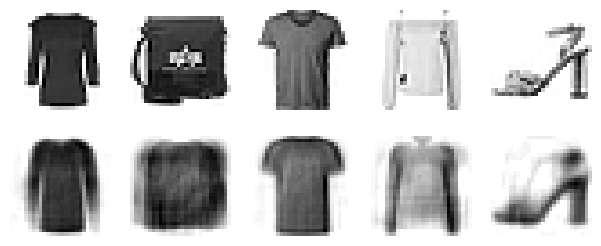

In [21]:
plot_reconstructions(stacked_ae)
plt.show()

Las reconstrucciones parecen borrosas, pero hay que recordar que las imágenes se comprimieron a sólo 30 números, en lugar de 784.

## Visualización del conjunto de datos MNIST de moda

In [22]:
from sklearn.manifold import TSNE

In [23]:
X_valid_compressed = stacked_encoder.predict(X_valid)

157/157 [==============================] - 0s 2ms/step


In [24]:
tsne = TSNE(init="pca", learning_rate="auto", random_state=42)

In [25]:
X_valid_2D = tsne.fit_transform(X_valid_compressed)

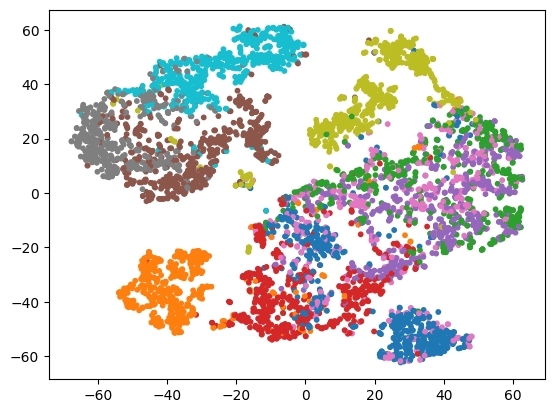

In [26]:
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap="tab10")
plt.show()

Hagamos este diagrama un poco más bonito (adaptado de [este ejemplo de Scikit-Learn](https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html)):

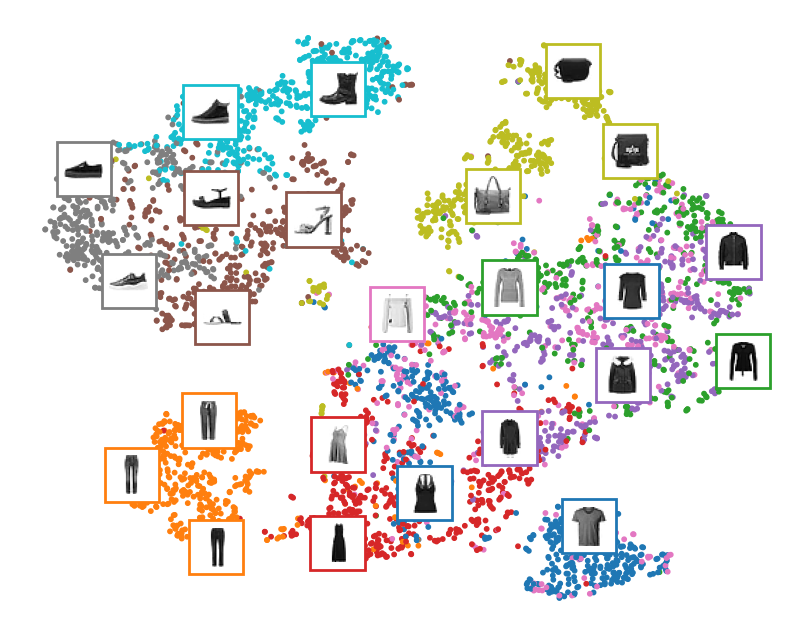

In [27]:
# Beautifies the previous diagram for the book
import matplotlib as mpl

plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
Z = X_valid_2D
Z = (Z - Z.min()) / (Z.max() - Z.min())  # normalize to the 0-1 range
plt.scatter(Z[:, 0], Z[:, 1], c=y_valid, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(Z):
    dist = ((position - image_positions) ** 2).sum(axis=1)
    if dist.min() > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_valid[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_valid[index]), "lw": 2})
        plt.gca().add_artist(imagebox)

plt.axis("off")
plt.show()

### Contrapesos de atado

Es habitual vincular los pesos del codificador y el decodificador, utilizando simplemente la transposición de los pesos del codificador como pesos del decodificador. Para ello, tenemos que utilizar una capa personalizada.

In [28]:
class DenseTranspose(tf.keras.layers.Layer):
    def __init__(self, dense, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.dense = dense
        self.activation = tf.keras.activations.get(activation)

    def build(self, batch_input_shape):
        self.biases = self.add_weight(name="bias",
                                      shape=self.dense.input_shape[-1],
                                      initializer="zeros")
        super().build(batch_input_shape)

    def call(self, inputs):
        Z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
        return self.activation(Z + self.biases)

In [29]:
dense_1 = tf.keras.layers.Dense(100, activation="relu")
dense_2 = tf.keras.layers.Dense(30, activation="relu")

In [30]:
tied_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    dense_1,
    dense_2
])

tied_decoder = tf.keras.Sequential([
    DenseTranspose(dense_2, activation="relu"),
    DenseTranspose(dense_1),
    tf.keras.layers.Reshape([28, 28])
])

In [31]:
tied_ae = tf.keras.Sequential([tied_encoder, tied_decoder])

In [32]:
# Compiles and fits the model
tied_ae.compile(loss="mse", optimizer="nadam")
history = tied_ae.fit(X_train, X_train, epochs=10,
                      validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 9s 4ms/step - loss: 0.0232 - val_loss: 0.0174
Epoch 2/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0165 - val_loss: 0.0161
Epoch 3/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0156 - val_loss: 0.0153
Epoch 4/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0151 - val_loss: 0.0149
Epoch 5/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.0147 - val_loss: 0.0147
Epoch 6/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.0144 - val_loss: 0.0144
Epoch 7/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.0142 - val_loss: 0.0143
Epoch 8/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0141 - val_loss: 0.0141
Epoch 9/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0139 - val_loss: 0.0140
Epoch 10/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.013

1/1 [==============================] - 0s 67ms/step


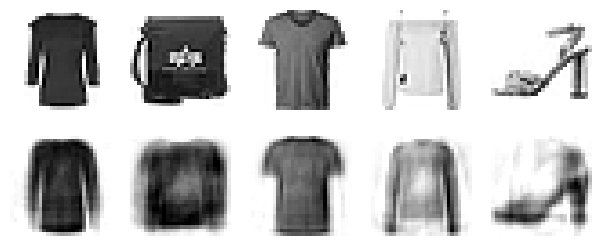

In [33]:
# Plots reconstructions
plot_reconstructions(tied_ae)
plt.show()

### Entrenar un Autoencoder cada vez

In [34]:
def train_autoencoder(n_neurons, X_train, X_valid, n_epochs=10,
                      output_activation=None):
    n_inputs = X_train.shape[-1]
    encoder = tf.keras.layers.Dense(n_neurons, activation="relu")
    decoder = tf.keras.layers.Dense(n_inputs, activation=output_activation)
    autoencoder = tf.keras.Sequential([encoder, decoder])
    autoencoder.compile(loss="mse", optimizer="nadam")
    autoencoder.fit(X_train, X_train, epochs=n_epochs,
                    validation_data=(X_valid, X_valid))
    return encoder, decoder, encoder(X_train), encoder(X_valid)

In [35]:
X_train_flat = tf.keras.layers.Flatten()(X_train)
X_valid_flat = tf.keras.layers.Flatten()(X_valid)

In [36]:
enc1, dec1, X_train_enc1, X_valid_enc1 = train_autoencoder(
    100, X_train_flat, X_valid_flat)
enc2, dec2, _, _ = train_autoencoder(
    30, X_train_enc1, X_valid_enc1, output_activation="relu")

Epoch 1/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0185 - val_loss: 0.0120
Epoch 2/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0110 - val_loss: 0.0105
Epoch 3/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.0102 - val_loss: 0.0109
Epoch 4/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.0099 - val_loss: 0.0097
Epoch 5/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.0096 - val_loss: 0.0095
Epoch 6/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.0094 - val_loss: 0.0092
Epoch 7/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.0092 - val_loss: 0.0091
Epoch 8/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.0091 - val_loss: 0.0114
Epoch 9/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0090 - val_loss: 0.0090
Epoch 10/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.009

In [37]:
stacked_ae_1_by_1 = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    enc1, enc2, dec2, dec1,
    tf.keras.layers.Reshape([28, 28])
])

1/1 [==============================] - 0s 97ms/step


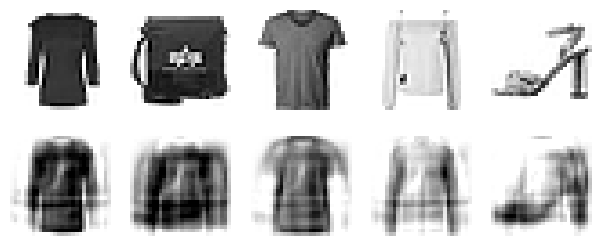

In [38]:
plot_reconstructions(stacked_ae_1_by_1)
plt.show()

Si es necesario, podemos seguir entrenando el autocodificador apilado completo durante unas cuantas épocas:

In [39]:
stacked_ae_1_by_1.compile(loss="mse", optimizer="nadam")
history = stacked_ae_1_by_1.fit(X_train, X_train, epochs=5,
                                validation_data=(X_valid, X_valid))

Epoch 1/5
1719/1719 [==============================] - 9s 4ms/step - loss: 0.0165 - val_loss: 0.0157
Epoch 2/5
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0149 - val_loss: 0.0145
Epoch 3/5
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0141 - val_loss: 0.0141
Epoch 4/5
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0137 - val_loss: 0.0136
Epoch 5/5
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0134 - val_loss: 0.0135


1/1 [==============================] - 0s 62ms/step


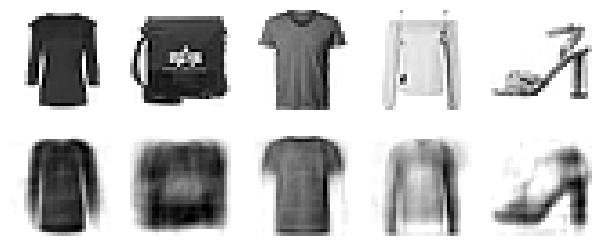

In [40]:
plot_reconstructions(stacked_ae_1_by_1)
plt.show()

___

## Convolutional Autoencoders

Construyamos un Autoencoder apilado con 3 capas ocultas y 1 capa de salida (es decir, 2 Autoencoders apilados).

In [41]:
conv_encoder = tf.keras.Sequential([
    tf.keras.layers.Reshape([28, 28, 1]),
    tf.keras.layers.Conv2D(16, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2),  # output: 14 × 14 x 16
    tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2),  # output: 7 × 7 x 32
    tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2),  # output: 3 × 3 x 64
    tf.keras.layers.Conv2D(30, 3, padding="same", activation="relu"),
    tf.keras.layers.GlobalAvgPool2D()  # output: 30
])
conv_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(3 * 3 * 16),
    tf.keras.layers.Reshape((3, 3, 16)),
    tf.keras.layers.Conv2DTranspose(32, 3, strides=2, activation="relu"),
    tf.keras.layers.Conv2DTranspose(16, 3, strides=2, padding="same",
                                    activation="relu"),
    tf.keras.layers.Conv2DTranspose(1, 3, strides=2, padding="same"),
    tf.keras.layers.Reshape([28, 28])
])

In [42]:
conv_ae = tf.keras.Sequential([conv_encoder, conv_decoder])

In [43]:
# Compiles and fits the model
conv_ae.compile(loss="mse", optimizer="nadam")

In [44]:
history = conv_ae.fit(X_train, X_train, epochs=10,
                      validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 23s 8ms/step - loss: 0.0299 - val_loss: 0.0215
Epoch 2/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.0191 - val_loss: 0.0178
Epoch 3/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.0169 - val_loss: 0.0181
Epoch 4/10
1719/1719 [==============================] - 13s 7ms/step - loss: 0.0158 - val_loss: 0.0152
Epoch 5/10
1719/1719 [==============================] - 13s 7ms/step - loss: 0.0149 - val_loss: 0.0146
Epoch 6/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.0143 - val_loss: 0.0140
Epoch 7/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.0138 - val_loss: 0.0136
Epoch 8/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.0134 - val_loss: 0.0135
Epoch 9/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.0130 - val_loss: 0.0131
Epoch 10/10
1719/1719 [==============================] - 12s 7ms/step - l

1/1 [==============================] - 0s 291ms/step


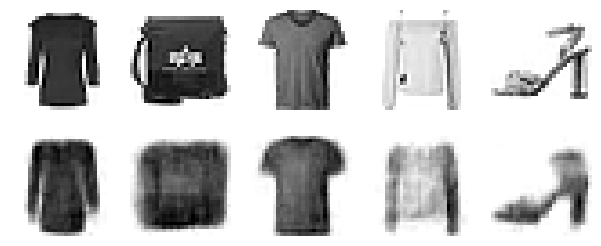

In [45]:
# Shows the reconstructions
plot_reconstructions(conv_ae)
plt.show()

___

## Denoising Autoencoders

In [46]:
dropout_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(30, activation="relu")
])
dropout_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(28 * 28),
    tf.keras.layers.Reshape([28, 28])
])
dropout_ae = tf.keras.Sequential([dropout_encoder, dropout_decoder])

In [47]:
# Compiles and fits the model
dropout_ae.compile(loss="mse", optimizer="nadam")

In [48]:
history = dropout_ae.fit(X_train, X_train, epochs=10,
                         validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 9s 4ms/step - loss: 0.0288 - val_loss: 0.0215
Epoch 2/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0221 - val_loss: 0.0198
Epoch 3/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0210 - val_loss: 0.0192
Epoch 4/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0205 - val_loss: 0.0188
Epoch 5/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0201 - val_loss: 0.0185
Epoch 6/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0198 - val_loss: 0.0183
Epoch 7/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0195 - val_loss: 0.0180
Epoch 8/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0192 - val_loss: 0.0175
Epoch 9/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0189 - val_loss: 0.0173
Epoch 10/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.018

1/1 [==============================] - 0s 68ms/step


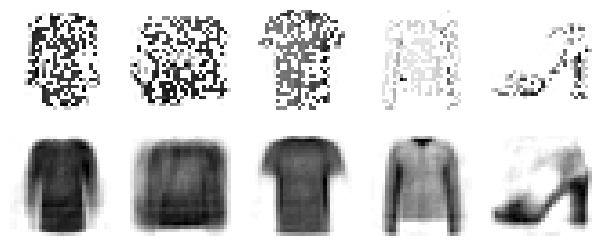

In [49]:
# This cell generates and saves Figure 17–9
dropout = tf.keras.layers.Dropout(0.5)
plot_reconstructions(dropout_ae, dropout(X_valid, training=True))
plt.show()

Si quieres, puedes probar a sustituir la capa `Dropout` por `tf.keras.layers.GaussianNoise(0.2)`.

___

## Sparse Autoencoder

Utilicemos la función de activación sigmoidea en la capa de codificación. Añadamos también $\ell_1$ regularización a la misma: para ello, añadimos una capa `ActivityRegularization` después de la capa de codificación. Alternativamente, podríamos añadir `activity_regularizer=tf.keras.regularizers.l1(1e-4)` a la propia capa de codificación.

In [50]:
sparse_l1_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(300, activation="sigmoid"),
    tf.keras.layers.ActivityRegularization(l1=1e-4)
])
sparse_l1_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(28 * 28),
    tf.keras.layers.Reshape([28, 28])
])

In [51]:
sparse_l1_ae = tf.keras.Sequential([sparse_l1_encoder, sparse_l1_decoder])

In [52]:
# Compiles and fits the model
sparse_l1_ae.compile(loss="mse", optimizer="nadam")

In [53]:
history = sparse_l1_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 10s 5ms/step - loss: 0.0280 - val_loss: 0.0194
Epoch 2/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0172 - val_loss: 0.0158
Epoch 3/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.0149 - val_loss: 0.0145
Epoch 4/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.0138 - val_loss: 0.0134
Epoch 5/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0130 - val_loss: 0.0128
Epoch 6/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.0124 - val_loss: 0.0122
Epoch 7/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0120 - val_loss: 0.0120
Epoch 8/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.0116 - val_loss: 0.0116
Epoch 9/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.0113 - val_loss: 0.0115
Epoch 10/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.01

1/1 [==============================] - 0s 70ms/step


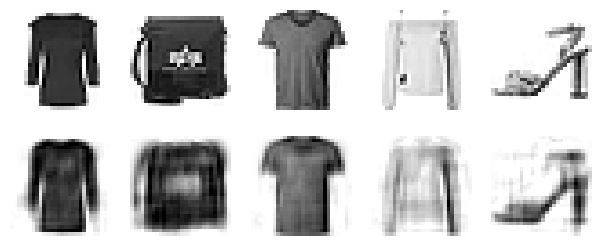

In [54]:
# extra code – shows the reconstructions
plot_reconstructions(sparse_l1_ae)
plt.show()

Vamos a trazar la pérdida de Divergencia KL, frente a la MAE y MSE:

NameError: ignored

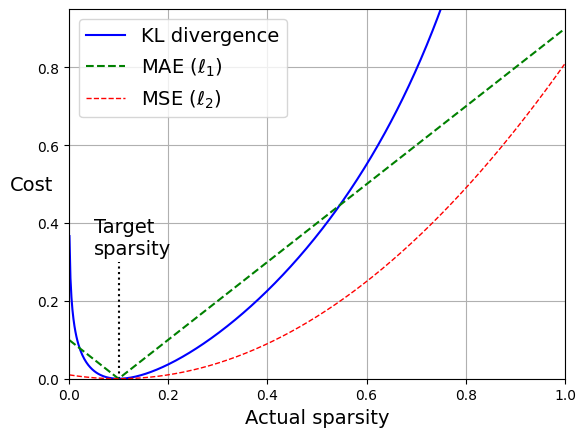

In [55]:
# extra code – this cell generates and saves Figure 17–10
p = 0.1
q = np.linspace(0.001, 0.999, 500)
kl_div = p * np.log(p / q) + (1 - p) * np.log((1 - p) / (1 - q))
mse = (p - q) ** 2
mae = np.abs(p - q)
plt.plot([p, p], [0, 0.3], "k:")
plt.text(0.05, 0.32, "Target\nsparsity", fontsize=14)
plt.plot(q, kl_div, "b-", label="KL divergence")
plt.plot(q, mae, "g--", label=r"MAE ($\ell_1$)")
plt.plot(q, mse, "r--", linewidth=1, label=r"MSE ($\ell_2$)")
plt.legend(loc="upper left", fontsize=14)
plt.xlabel("Actual sparsity")
plt.ylabel("Cost", rotation=0)
plt.axis([0, 1, 0, 0.95])
plt.grid(True)

Definamos un regularizador personalizado para la regularización de la Divergencia KL:

In [ ]:
kl_divergence = tf.keras.losses.kullback_leibler_divergence

class KLDivergenceRegularizer(tf.keras.regularizers.Regularizer):
    def __init__(self, weight, target):
        self.weight = weight
        self.target = target

    def __call__(self, inputs):
        mean_activities = tf.reduce_mean(inputs, axis=0)
        return self.weight * (
            kl_divergence(self.target, mean_activities) +
            kl_divergence(1. - self.target, 1. - mean_activities))

Ahora vamos a utilizar este regularizador para empujar el modelo a tener un 10% de sparsity en la capa de codificación:

In [ ]:
kld_reg = KLDivergenceRegularizer(weight=5e-3, target=0.1)
sparse_kl_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(300, activation="sigmoid",
                          activity_regularizer=kld_reg)
])
sparse_kl_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(28 * 28),
    tf.keras.layers.Reshape([28, 28])
])

In [ ]:
sparse_kl_ae = tf.keras.Sequential([sparse_kl_encoder, sparse_kl_decoder])

In [ ]:
# Compiles and fits the model
sparse_kl_ae.compile(loss="mse", optimizer="nadam")

In [ ]:
history = sparse_kl_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

In [ ]:
# extra code – shows the reconstructions
plot_reconstructions(sparse_kl_ae)
plt.show()

___

# Programando una GAN

A continuación se presentarán los pasos para implementar una GAN que permite entrenar un *Generador* que sintetiza dígitos escritos a mano que parecen reales usando *Deep Convolutional Generative Adversarial Networks (DCGAN)*

Capturas de las imágenes producidas por el Generador en diferentes *epochs* durante su proceso de entrenamiento (se indica en qué número de epoch se ha generado cada imagen).

* Se usa el Generador para generar 100 imágenes
* Se podrá observar fácilmente que al inicio del entrenamiento las imágenes aparecen como ruido aleatorio
* A medida que va avanzando el entrenamiento (va avanzando el número de *epochs*) los dígitos generados se parecen cada vez más a dígitos reales escritos a mano.
* El objetivo final en un caso real es que el Generador sintetice imágenes de 28 × 28 que se confundan como datos reales del conjunto MNIST (conjunto de imágenes que hemos considerado como «reales»)

#### Descarga de los datos  y preprocesado de los datos

Descargar y preparar el conjunto de datos con el que entrenaremos la GAN.
Ahora ya podemos descargar las imágenes del conjunto de datos **MNIST** de dígitos escritos a mano, que serán las imágenes que consideraremos *«reales»* para este ejemplo. Podemos hacerlo directamente desde ``keras.datasets`` y preparar las imágenes para ser usadas por las redes con el siguiente código

In [ ]:
(train_images, _), (_, _) = tf.keras.datasets.mnist.load_data()

train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')

En este caso solo interesan las imágenes (no se descargan las labels ni los datos de prueba)

Las imágenes se normalizan en el rango ``[-1, 1]`` para poder usar como función de activación en la capa final del Generador la función ``tanh``:

In [ ]:
train_images = (train_images - 127.5) / 127.5

Se barajan y preparan los datos en lotes con el siguiente código:

In [ ]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Creación de los modelos

A continuación, se pasa a crear las redes neuronales que actuarán de Generador y Discriminador.

### Generador

Siguiendo el esquema que había descrito, el Generador recibe como entrada ruido, que puede obtener por ejemplo con ``tf.random.normal``.
De este ruido debe crear una imagen de $28×28$ píxeles

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Reshape, Conv2DTranspose, BatchNormalization, LeakyReLU

In [ ]:
def make_generator_model():
    model = Sequential()
    model.add(Dense(7*7*256, use_bias=False, input_shape=(100,)))

    model.add(Reshape((7, 7, 256)))

    model.add(Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))

    model.add(Conv2DTranspose(64, (5, 5), strides=(1, 1), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))

    model.add(Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', activation='tanh'))

    return model

In [ ]:
generator = make_generator_model()
generator.summary ()

Descripción del modelo:
1. Capa densa que recoge el vector de ruido de entrada y lo transforma en un tensor tridimensional
2. En las capas sucesivas se va transformando hasta llegar a una salida de 28 × 28 × 1.
3. La red aumenta los tamaños de los mapas de características con la capa Conv2DTranspose.
    * La capa convolución transpuesta se usa generalmente para aumentar el mapa de características.
    * La convolución transpuesta funciona insertando ceros entre los elementos de los mapas de características de entrada y, después, aplicando una convolución normal.
4. La capa ``LeakyReLU`` es una versión modificada de la función de activación ReLU que tiene una pequeña pendiente para valores negativos, en lugar de cero como la ReLU (determinada por el argumento).
    * Esta se utiliza en cada capa excepto en la última capa.
    * Esta capa es una funciones de activación avanzadas en Keras y solo está disponible como capa y no como funciones de activación.
5. En la última capa se ha usado una función de activación ``tanh``:
    * ``tanh`` tiende a producir imágenes más nítidas que la sigmoide (rango típico de 0 a1)
6. Se usa la capa ``BatchNormalization`` para normalizar las entradas de la capa

Podemos comprobar que la red funciona como se espera con el siguiente código, en el que el Generador genera una instancia de datos fake:

In [ ]:
noise_dim = 100
noise = tf.random.normal([1, noise_dim])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

### Discriminador

Por otra parte, el Discriminator recibe imágenes de $28×28×1$ píxeles y saca una probabilidad que indica si esta imagen de entrada la considera real (en lugar de fake)

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, LeakyReLU, Conv2D

In [ ]:
def make_discriminator_model():
    model = Sequential()
    model.add(Conv2D(32, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(LeakyReLU(alpha=0.01))

    model.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))

    model.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))

    model.add(Conv2D(128*2, (5, 5), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))

    model.add(Conv2D(128*3, (5, 5), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))

    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

In [ ]:
discriminator = make_discriminator_model()
discriminator.summary ()

Esta red se construye con tres capas convolucionales de 32, 64 y 128 neuronas, con función de activación ``LeakyReLU`` y ``BatchNormalization``. La última capa es una capa densa con una función de activación sigmoide.

El Discriminador se usará para clasificar las imágenes generadas como reales o fake, generando valores:
* Próximos al 1 para imágenes que considera reales
* Próximos a 0 para imágenes que considera fake.

Podemos comprobar que el Discriminador funciona como creemos con el siguiente código:

In [ ]:
decision = discriminator(generated_image)
print (decision)

## Funciones de *Loss* y optimizadores


Una vez los modelos del Generador y Discriminador fueron creados, el siguiente paso para entrenar las redes es establecer la función de pérdida y el optimizador que se usará para el proceso de entrenamiento.
* Anteriormente esto se ha indicado con los argumentos del método ``compile()`` que luego se usan cuando se entrena el modelo al ejecutar el método ``fit()``
* Ahora se tinen **dos redes neuronales**, se requieren dos funciones de pérdida y dos optimizadores.
* Los parámetros de ambas redes están interrelacionados en el cálculo de la función de pérdida.

### Funciones de pérdida

Para las funciones de pérdida de ambas redes neuronales se utilizá la *binary cross entropy*, que es una medida de la diferencia entre las probabilidades calculadas y las probabilidades reales de predicciones en los casos donde solo hay **dos clases posibles** en las que pueden ser clasificados los datos de entrada.

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Discriminator loss

Con la función auxiliar ``cross_entropy`` se definirá la función ``discriminator_loss()`` para cuantificar una *loss* del Discriminador que nos indicará cómo de bien el Discriminador consigue distinguir imágenes reales de imágenes fake en una iteración
* La función recibe en el primer argumento (real_output) la predicción que ha hecho el Discriminador de un batch de imágenes reales
* En el segundo argumento (fake_output) la predicción que ha hecho de un batch una imagen fake.

Si la predicción fuera la correcta, para una imagen real la predicción debería ser 1 y para una imagen fake debería ser 0.
* Esta función compara el batch de imágenes reales predecidas por el Discriminador con un array de unos ``(tf.ones_like(real_output))`` y el batch de imágenes fake con un array de ceros ``(tf.zeros_like(real_output))``.

La loss para esta iteración está compuesta tanto por los errores de predicción de imágenes reales como por los errores de las imágenes fake; por tanto, se deben sumar.

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Generator loss

La manera de construir la función ``generator_loss`` para cuantificar una loss del Generador será muy parecida:
* La loss del Generador deberá cuantificar cómo de bien fue capaz de engañar al Discriminador
* Se comparan las decisiones del Discriminador sobre las imágenes generadas por el Generador con una matriz de unos

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

### Optimizadores

Los optimizadores del Discriminador y del Generador son diferentes y se requieren dos, ya que se entrenarán las dos redes por separado:

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

Para la optimización de ambas redes, es sescoge el algoritmo *Adam*. *Adam* se ha convertido en el optimizador para la mayoría de las implementaciones de GAN porque se ha demostrado que en la práctica tiene un rendimiento superior a otros métodos de optimización en este tipo de redes.

## Entrenamiento con la API de bajo nivel de TensorFlow

Anteriormente se ha utilizado el objeto ``tf.keras.Model``, a través de sus métodos ``fit()`` y ``compile()``, para entrenar a los modelos.
* Muy útil, ya que permite ahorrar escribir el código de bucle de entrenamiento
* Da suficiente control con *callbacks*, *métricas*, etc.

**¿Cómo se puede especificar con el método ``fit()`` que esta red neuronal tiene dos funciones de pérdida y dos optimizadores?** La respuesta es ¡no se puede!

En **TensorFlow 2.0** se puede utilizar la API de bajo nivel para escribir bucles de entrenamiento personalizados. Se utilizará el ``GradientTape`` de la API de bajo nivel, que  permite más control para personalizar el bucle de entrenamiento:
* Entrenar a la vez las dos redes neuronales que se requieren para una GAN

En general, los códigos utilizarán mayormente las API de alto nivel (especialmente ``tf.keras`` y ``tf.data``), pero cuando se necesita más flexibilidad, se utiliza la API de Python de nivel inferior.

### Entrenamiento de las redes GAN

Es necesario crear un bucle de entrenamiento personalizado utilizando la API de bajo nivel de TensorFlow. Se recreará una función ``train()`` a ala cual se le pasarán en los argumentos los datos de entrenamiento y el número de epochs que se quieren ejecutar para entrenar simultaneamente el Generador y el Discriminador.

La función ``train_step`` llamada dentro de ``train()`` representa un paso del bucle de entrenamiento (en sustitución del método ``fit()`` usando la API de bajo nivel de TensorFlow 2). Se define en 4 pasos:
1. Creación de un conjunto de semillas de ruido con el que el Generador pueda generar las imágenes fake correspondientes (recordemos que estamos procesando las imágenes por lotes de tamaño BATCH_SIZE y que, por tanto, genera un vector de semillas, no una sola semilla)
```Python
noise = tf.random.normal([BATCH_SIZE, noise_dim])
```
Con este vector de ruido el Generador genera un batch de imágenes fake:
```Python
generated_images = generator(noise, training=True)
```
Se usa el Discriminador para clasificar un batch de imágenes reales extraídas del conjunto MNIST (recibidas como argumento) y un batch de imágenes fake acabadas de producir por el Generador:
```Python
real_output = discriminator(images, training=True)
fake_output = discriminator(generated_images, training=True)
```
2. Cuando ya se tienen los valores obtenidos por el Generador y el Discriminador, se calcula la loss de ambos modelos con las funciones que se han definido anteriormente
```Python
gen_loss = generator_loss(fake_output)
disc_loss = discriminator_loss(real_output, fake_output)
```
    * Los pasos anteriores se ejecutan dentro del contexto (context) de ``tf.GradientTape`` indicados por ``with``.
    * En concreto, se están considerando dos contextos, uno para la información del Generador (``gen_tape``) y otro para la información del Discriminador (``disc_tape``).
    * ``tf.GradientTape`` permite que se *«graben»* en un objeto las operaciones ejecutadas en el contexto para permitir obtener los gradientes con respecto a la loss
3. Se debe propagar hacia atrás la loss para que llegue a todas las variables que conforman los parámetros (entrenables) para cada una de las dos redes neuronales. Esto es fácil una vez grabadas las operaciones en los respectivos contextos ``gen_tape`` y ``disc_tape``, aplicando el método ``gradient()`` para obtener los gradientes con respecto a la función de pérdida para las dos redes:
```Python
gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
```
4. Utilizar la información de los gradientes propagada para actualizar con el algoritmo de descenso del gradiente las variables correspondientes a los parámetros entrenables de cada una de las redes neuronales. Para ello simplemente hace falta usar el método ``apply_gradients()`` de los optimizadores de ambas redes
```Python
generator_optimizer.apply_gradients(zip(gradients_of_generator,
                                        generator.trainable_variables))
discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator,
                                            discriminator.trainable_variables))
```

In [ ]:
@tf.function # Decorador: timizada a nivel interno para poder ser acelerada en el hardware disponible.
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

#### Training loop

Este método ejecuta un doble bucle, como se ve en el siguiente código:
* El primer bucle tiene tantas iteraciones como epochs hemos indicado en el argumento, y el segundo itera para todos los batch del dataset.

* El cuerpo del bucle simplemente llama al método ``train_step``,que realiza todo el trabajo requerido para calcular las loss y actualizar los parámetros de las dos redes, para todas las imágenes de un batch en una epoch.

In [ ]:
import time

grid_size_x= 10
grid_size_y= 10
seed = tf.random.normal([grid_size_x*grid_size_y , noise_dim])

def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

    for image_batch in dataset:
        train_step(image_batch)

    generate_images(generator,seed)
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    generate_images(generator, seed)

Después de cada epoch se invoca a la función ``generate_images`` que visualiza por pantalla predicciones generadas por el Generador, y para ello usa las variables ``seed``, ``grid_size_x`` y ``grid_size_y``

#### Visualización de las imagenes
Función auxiliar para visualizar las imagenes que genera el Generador para ver que va aprendiendo

In [ ]:
def generate_images(model, test_input):

    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(grid_size_x,grid_size_y))

    for i in range(predictions.shape[0]):
        plt.subplot(grid_size_x, grid_size_y, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.show()

### Entrenamiento del modelo

In [ ]:
## %%time
EPOCHS = 12000
train(train_dataset, EPOCHS)

# Detección de fraudes usando autoencoders

Este código fuente muestra cómo detectar transacciones fraudulentas en tarjetas débito y crédito usando un autoencoder.
El set de datos (creditcard.csv) se puede descargar de este [enlace](https://drive.google.com/file/d/1Lf4tMOt45IFARFO-dNl4-Df8x-gjUMu5/view).
    
Contiene $284,315$ registros con transacciones normales y $492$ fraudulentas. Una vez entrenado el autoencoder se logrará un recall igual a 0.92.
Este código está basado en el post de David Ellison

### LECTURA DEL SET DE DATOS

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

datos = pd.read_csv("https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv")
print(datos.head())

nr_clases = datos['Class'].value_counts(sort=True)
print(nr_clases)

## ANÁLISIS EXPLORATORIO DE LOS DATOS

#### Cantidad de registros normales vs. fraudulentos

In [ ]:
nr_clases.plot(kind = 'bar', rot=0)
plt.xticks(range(2), ['Normales', 'Fraudulentos'])
plt.title("Distribución de los datos")
plt.xlabel("Clase")
plt.ylabel("Cantidad")
plt.show()

##### Monto de las transacciones vs. tiempo

In [ ]:
normales = datos[datos.Class==0]
fraudulentos = datos[datos.Class==1]
plt.scatter(normales.Time/3600, normales.Amount,
            alpha = 0.5, c='#19323C', label='Normales', s=3)
plt.scatter(fraudulentos.Time/3600, fraudulentos.Amount,
            alpha = 0.5, c='#F2545B', label='Fraudulentos', s=3)
plt.xlabel('Tiempo desde la primera transacción (h)')
plt.ylabel('Monto (Euros)')
plt.legend(loc='upper right')
plt.show()

#### Distribución de las características V1 a V28 en normales y fraudulentos

In [ ]:
import matplotlib.gridspec as gridspec
import seaborn as sns

v_1_28 = datos.iloc[:,1:29].columns
gs = gridspec.GridSpec(28, 1)
for i, cn in enumerate(datos[v_1_28]):
    sns.distplot(datos[cn][datos.Class == 1], bins=50,
                 label='Fraudulentos', color='#F2545B')
    sns.distplot(datos[cn][datos.Class == 0], bins=50,
                 label='Normales', color='#19323C')
    plt.xlabel('')
    plt.title('Histograma característica: ' + str(cn))
    plt.legend(loc='upper right')
    plt.show()

## PRE-PROCESAMIENTO

#### La variable "Tiempo" no aporta información. La eliminaremos

In [ ]:
from sklearn.preprocessing import StandardScaler
datos.drop(['Time'], axis=1, inplace=True)
datos['Amount'] = StandardScaler().fit_transform(datos['Amount'].values.reshape(-1,1))

from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(datos, test_size=0.2, random_state=42)
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)
X_train = X_train.values

Y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)
X_test = X_test.values

## AUTOENCODER: 29-20-14-20-29, tanh-relu-tanh-relu

In [ ]:
import numpy as np
np.random.seed(5)
from keras.models import Model, load_model
from keras.layers import Input, Dense

In [ ]:
dim_entrada = X_train.shape[1]          # 29
capa_entrada = Input(shape=(dim_entrada,))

encoder = Dense(20, activation='tanh')(capa_entrada)
encoder = Dense(14, activation='relu')(encoder)

decoder = Dense(20, activation='tanh')(encoder)
decoder = Dense(29, activation='relu')(decoder)

autoencoder = Model(inputs=capa_entrada, outputs=decoder)

In [ ]:
from keras.optimizers import SGD
sgd = SGD(lr=0.01)
autoencoder.compile(optimizer='sgd', loss='mse')

nits = 100
tam_lote = 32
autoencoder.fit(X_train, X_train, epochs=nits, batch_size=tam_lote, shuffle=True, validation_data=(X_test,X_test), verbose=1)

## VALIDACIÓN

#### Predicción X_test -> Autoencoder -> X_pred

In [ ]:
X_pred = autoencoder.predict(X_test)
ecm = np.mean(np.power(X_test-X_pred,2), axis=1)
print(X_pred.shape)

# Gráfica precision-recall para determinar el umbral
from sklearn.metrics import confusion_matrix, precision_recall_curve
precision, recall, umbral = precision_recall_curve(Y_test, ecm)

plt.plot(umbral, precision[1:], label="Precision",linewidth=5)
plt.plot(umbral, recall[1:], label="Recall",linewidth=5)
plt.title('Precision y Recall para diferentes umbrales')
plt.xlabel('Umbral')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

#### Matriz de confusión

In [ ]:
umbral_fijo = 0.75
Y_pred = [1 if e > umbral_fijo else 0 for e in ecm]

conf_matrix = confusion_matrix(Y_test, Y_pred)
print(conf_matrix)

___
¡Todo bien! ¡Es todo por hoy! 😀